## Stroke Prediction
The World Health Organization (WHO) reports that stroke is the second most common cause of death worldwide, accounting for around 11% of all deaths.

Based on input variables including gender, age, various diseases, and smoking status, this dataset is used to determine whether a patient is likely to get a stroke. Each row in the data provides relevant information about the patient.

### Attribute Information
1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

## Import packages

In [85]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

import miceforest as mf
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Open dataset 

In [86]:
data = pd.read_csv("./dataset/strokedataset.csv")
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Handle missing value

In [87]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The dataset has 201 samples with no BMI value. Missing data could reduces the statistical power of the analysis. Instead of simply estimating it with the mean or median, we used MICE imputation methods.

### Imputation
MICE is a multiple imputation method used to replace missing data values in a dataset under certain assumptions about the mechanism of the missing data. (e.g. data randomly missing, data randomly completely missing).

In [88]:

def miceImputation(data,iteration): 
    data = data
    iteration = iteration 
    data['stroke'] = data['stroke'].astype('category')
    data['gender'] = data['gender'].astype('category')
    data['ever_married'] = data['ever_married'].astype('category')
    data['work_type'] = data['work_type'].astype('category')
    data['Residence_type'] = data['Residence_type'].astype('category')
    data['smoking_status'] = data['smoking_status'].astype('category')

    # Create kernels
    kernel = mf.KernelDataSet(
      data=data,
      save_all_iterations=True,
      random_state=1991
    )
    # Run the MICE algorithm for 5 iterations on each of the datasets
    kernel.mice(iteration,verbose=True)

    # Make a multiple imputed dataset with our new data
    data_imputed = kernel.impute_new_data(data)

    # Return a completed dataset
    completed_data = data_imputed.complete_data(0)
    missing = completed_data.isnull().sum()
    return completed_data, missing

data, missing = miceImputation(data,5)

1  | bmi
2  | bmi
3  | bmi
4  | bmi
5  | bmi
 | bmi | bmi | bmi | bmi | bmi

## Feature encoding

Machine learning models can only use numerical values. Therefore, it is necessary to convert the categorical values of the relevant features into numerical values.

In [89]:
data['smoking_status'] = data['smoking_status'].replace({'smokes':2,'formerly smoked':1,'never smoked':0,'Unknown':-1}).astype('int64')
data['stroke'] = data['stroke'].replace({'1':1,'0':0}).astype('int64')
data['ever_married'] = data['ever_married'].replace({'Yes':1,'No':0}).astype('int64')
data['gender'] = data['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype('int64')
data['Residence_type'] = data['Residence_type'].replace({'Rural':0,'Urban':1}).astype('int64')
data['work_type'] = data['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype('int64')

df = data.copy()
data


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,1,0,1,228.69,36.6,1,1
1,51676,1,61.0,0,0,1,1,0,202.21,24.7,0,1
2,31112,0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,60182,1,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1665,1,79.0,1,0,1,1,0,174.12,24.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,0,1,83.75,26.5,0,0
5106,44873,1,81.0,0,0,1,1,1,125.20,40.0,0,0
5107,19723,1,35.0,0,0,1,1,0,82.99,30.6,0,0
5108,37544,0,51.0,0,0,1,0,0,166.29,25.6,1,0


## Data Exploration

### The relationship between Age and stroke patients

/var/folders/hb/lfz9sxt1297dhcmxzrjgl5_h0000gn/T/ipykernel_20765/3621507819.py:16: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



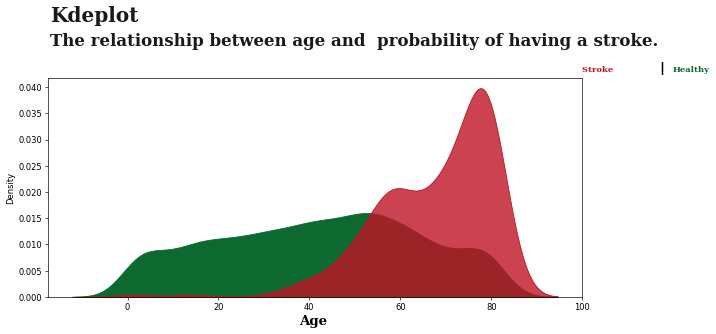

In [90]:
fig = plt.figure(figsize = (36,16), dpi = 60)
gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)
ax3 = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot

sns.kdeplot(data = df[df['stroke'] == 0], x = 'age',ax = ax3, shade = True,  alpha = 1, color = '#0c692f' )
sns.kdeplot(data = df[df['stroke'] == 1], x = 'age',ax = ax3, shade = True,  alpha =0.8, color = '#bf1324')

ax3.set_xlabel('Age ', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})
ax3.text(-17,0.0525,'Kdeplot', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(-17,0.048,'The relationship between age and  probability of having a stroke.', {'font':'Serif', 'weight':'bold','color': 'black', 'size':20}, alpha= 0.9)
ax3.text(100,0.043, 'Stroke ', {'font': 'Serif','weight':'bold','weight':'bold','style':'normal', 'color':'#bf1324'})
ax3.text(117,0.043, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(120,0.043, 'Healthy', {'font': 'Serif','weight':'bold','style':'normal', 'weight':'bold','color':'#0c692f'})

fig.show()

### The correlation between all variables

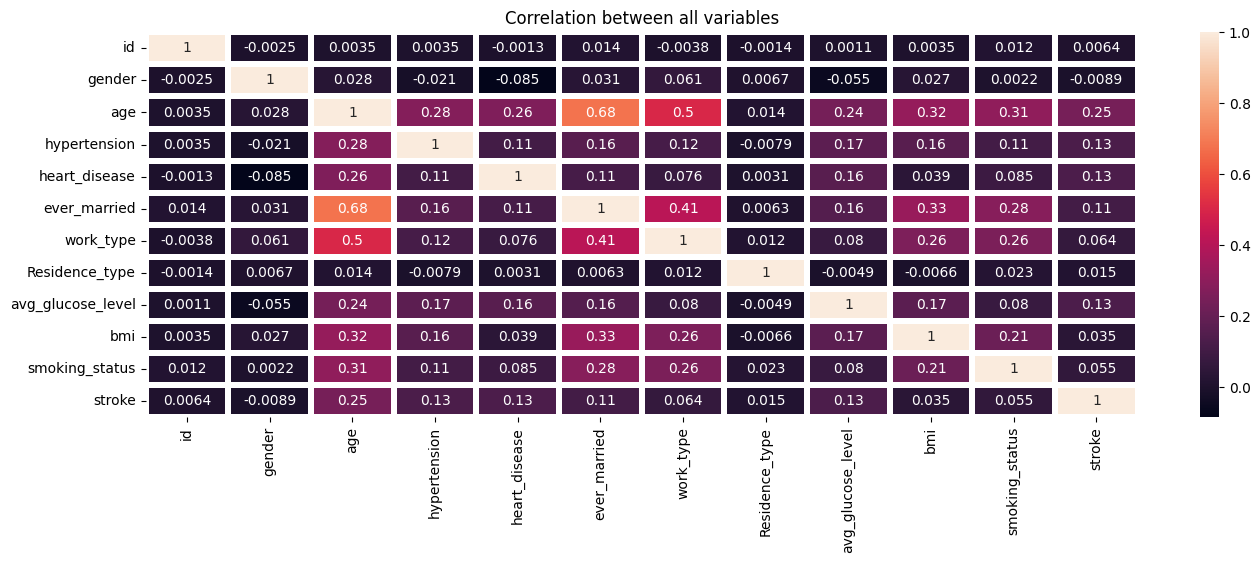

In [91]:
corrMatrix = df.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corrMatrix,annot=True, linewidths=3)
plt.title("Correlation between all variables")
plt.show()

### Heatmap of those variables affecting the probability of causing stroke

Text(-1.7, 1.1, 'Heatmap of those variables affecting\n the probability of causing stroke')

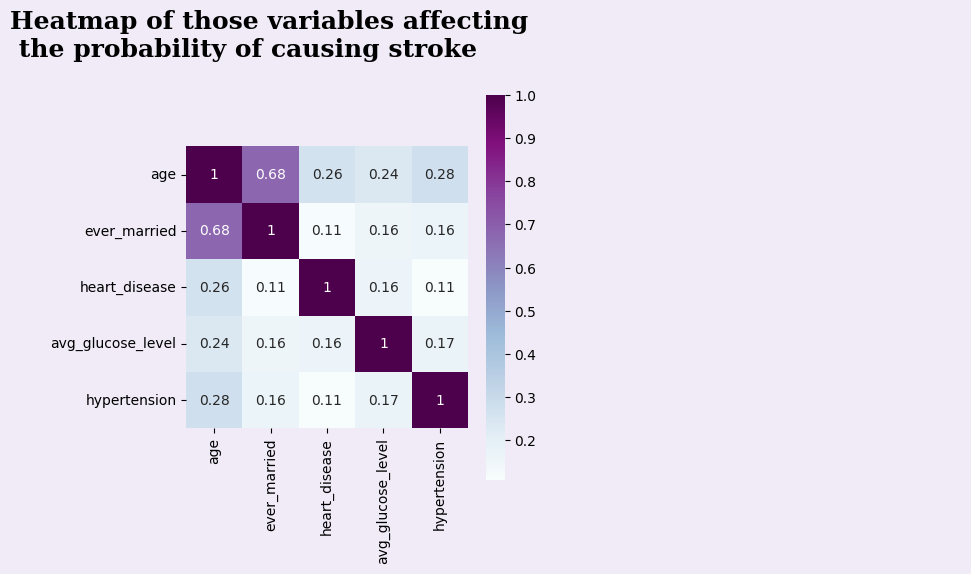

In [92]:
fig=plt.figure(figsize=(10,5),dpi=100)
gs=fig.add_gridspec(1,2)

ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
axes=[ax0,ax1]
background_color = '#f0ebf7'
# changing background color of our plots
for i in axes:
    i.set_facecolor(background_color)
# changing the figure background color
fig.patch.set_facecolor(background_color) 
# heatmap of numerical data
corrmat = df[["age","ever_married","heart_disease",'avg_glucose_level',"hypertension"]].corr()
sns.heatmap(ax=ax0,data=corrmat,annot=True,square=True, cmap="BuPu")
ax1.spines["left"].set_visible(False)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.tick_params(left=False, bottom=False)
for i in ["top","right","bottom","left"]:
    ax1.spines[i].set_visible(False)
plt.text(-1.7,1.1,'Heatmap of those variables affecting\n the probability of causing stroke',fontsize=18,fontweight='bold',fontfamily='serif')

### High levels of glucose and elderly have a high chance to cause stroke

[Text(0.5, 1.0, 'High levels of glucose and elderly have a high chance to cause stroke.')]

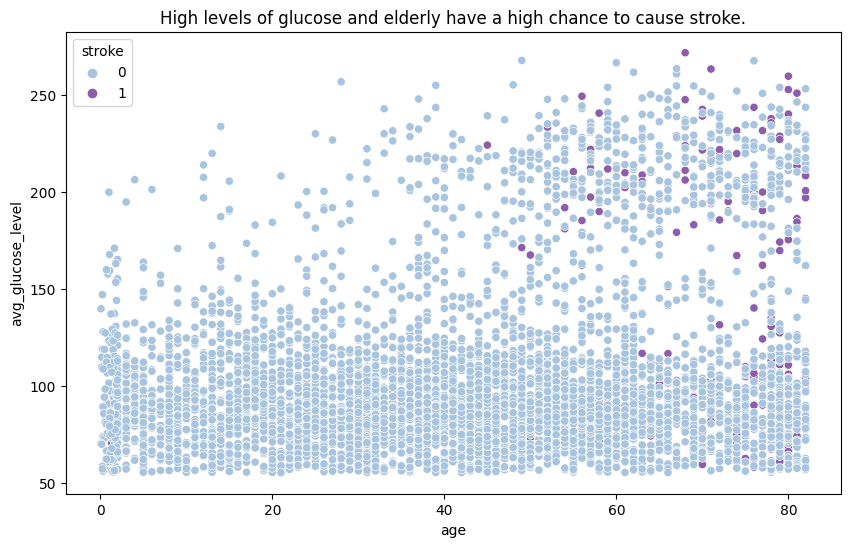

In [93]:
fig = plt.figure(figsize=(10,6))
# Age and Glucose
sns.scatterplot(x=df['age'],y=df['avg_glucose_level'],hue=df['stroke'],palette='BuPu').set(title='High levels of glucose and elderly have a high chance to cause stroke.')


### Obesity distribution pie chart of stroke patients

In [94]:
df['bmi_class'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,120], labels = ['Underweight(bmi<19)', 'Normal(19<bmi<25)', 'Overweight(25<bmi<30)', 'Obesity(bmi>30)'])
stroke_bmi = df[df['stroke'] == 1].bmi_class.value_counts()
dff = px.pd.DataFrame(stroke_bmi)
dfff=dff.reset_index()
fig = px.pie(dfff,values="bmi_class",names=dfff['index'],color_discrete_sequence=px.colors.sequential.RdBu)

fig.show()

## Train test split
Splitting the dataset can also be important to detect whether the model is underfitting or overfitting.

In [95]:
from sklearn.model_selection import train_test_split

X = data[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi','smoking_status']]
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 2)

## StandardScaler 

Feature normalization allows for faster convergence on machine learning.

In [96]:
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Upsample data
The challenge of imbalanced datasets is that most machine learning techniques will ignore, and have poor performance on the minority class.

In [97]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print(f'After OverSampling, the shape of X_tarin: {X_train_res.shape}')

print(f'After OverSampling, the shape of y_train: {y_train_res.shape} \n')

print(f"After OverSampling, the shape of '1': {sum(y_train_res==1)}")
print(f"After OverSampling, the shape of '0': {sum(y_train_res==0)}")

sm = SMOTE(random_state=0)
X_test, y_test = sm.fit_resample(X_test, y_test.ravel())


After OverSampling, the shape of X_tarin: (6806, 8)
After OverSampling, the shape of y_train: (6806,) 

After OverSampling, the shape of '1': 3403
After OverSampling, the shape of '0': 3403


## Model selection

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

models = []
models.append(['Logistic Regreesion', LogisticRegression(random_state=2)])
models.append(['Decision Tree', DecisionTreeClassifier(random_state=2)])
model_list = []
for m in range(len(models)):
    model = models[m][1]
    model.fit(X_train_res, y_train_res)
    model_list.append(model)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
    roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
    precision = precision_score(y_test, y_pred)  #Precision Score
    recall = recall_score(y_test, y_pred)  #Recall Score
    f1 = f1_score(y_test, y_pred)  #F1 Score
    print(models[m][0],':')
    print(cm)
    print('Accuracy Score: ',accuracy_score(y_test, y_pred))
    print('')
    print('ROC AUC Score: {:.2f}'.format(roc))
    print('')
    print('Precision: {:.2f}'.format(precision))
    print('')
    print('Recall: {:.2f}'.format(recall))
    print('')
    print('F1: {:.2f}'.format(f1))
    print('-----------------------------------')
    print('')


Logistic Regreesion :
[[1081  377]
 [ 208 1250]]
Accuracy Score:  0.7993827160493827

ROC AUC Score: 0.80

Precision: 0.77

Recall: 0.86

F1: 0.81
-----------------------------------

Decision Tree :
[[1327  131]
 [ 486  972]]
Accuracy Score:  0.7884087791495199

ROC AUC Score: 0.79

Precision: 0.88

Recall: 0.67

F1: 0.76
-----------------------------------



## Model evalution

In [99]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from imblearn.pipeline import Pipeline, make_pipeline
imba_pipeline = make_pipeline(SMOTE(random_state=0), 
                              LogisticRegression(random_state=2))
LR_CROSS_VAL = cross_val_score(imba_pipeline, X_train_res, y_train_res,scoring='f1', cv=10)

imba_pipeline = make_pipeline(SMOTE(random_state=0), 
                              DecisionTreeClassifier(random_state=2))
DT_CROSS_VAL = cross_val_score(imba_pipeline, X_train_res, y_train_res,scoring='f1', cv=10)


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Logistic Regression Cross Val Scores',
                                                                     'Decision Tree Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=LR_CROSS_VAL,name='Logistic Regression'),
    row=1, col=1)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=DT_CROSS_VAL,name='Decision Tree'),
    row=2, col=1)

fig.update_layout(height=700, width=900, title_text="Different Model 10 Fold Cross Validation with SMOTE")
fig.update_yaxes(title_text="F1 Score")
fig.update_xaxes(title_text="Fold #")

fig.show()

Decision tree models did the best on the average of overfitting the sample data. Decision Tree would be selected because of its higher performance.  

## Importance features

In [100]:
fig = go.Figure()
fig.add_trace(go.Bar(x=X.columns,y=model_list[1].feature_importances_))
fig.update_layout(title='The Importance Of The Attributes On Our Prediction',xaxis_title='Decision Tree',yaxis_title='F1 Score')
fig.show()